# Installing Tesseract

In [1]:
# !sudo apt install tesseract-ocr
# !pip install pytesseract
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
     - -------------------------------------- 0.1/5.0 MB 2.8 MB/s eta 0:00:02
     -- ------------------------------------- 0.3/5.0 MB 3.5 MB/s eta 0:00:02
     --- ------------------------------------ 0.5/5.0 MB 3.1 MB/s eta 0:00:02
     ---- ----------------------------------- 0.6/5.0 MB 3.2 MB/s eta 0:00:02
     ------ --------------------------------- 0.8/5.0 MB 3.5 MB/s eta 0:00:02
     ------- -------------------------------- 1.0/5.0 MB 3.5 MB/s eta 0:00:02
     -------- ------------------------------- 1.1/5.0 MB 3.5 MB/s eta 0:00:02
     ---------- ----------------------------- 1.3/5.0 MB 3.6 MB/s eta 0:00:02
     ----------- ---------------------------- 1.5/5.0 MB 3.5 MB/s eta 0:00:02
     ------------ --------------------------- 1.6/5.0 MB 3.6 MB/s eta 0:00:01
     -------------- ------------------------- 1.8/5.0 MB 3.5 MB/s eta 0:00:01
     -------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import cv2
# import numpy as np
# import pytesseract

# LOAD DATA

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

In [2]:
import torch

# Mengecek apakah CUDA (GPU) tersedia
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available!
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# Path ke folder dataset
# Ipang
# dataset_dir = "/content/drive/MyDrive/Klasifikasi Suara Pemilu"
# Whisnu
# dataset_dir = "/content/drive/MyDrive/Collab/[01] PIM/datasets-angka"
dataset_dir = "./Balanced-Datasets"

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformasi gambar untuk training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Augmentasi: flip horizontal
    transforms.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2)),  # Augmentasi: shear dan zoom
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisasi gambar
])

# Transformasi gambar untuk validation (hanya Resize dan Normalize)
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisasi gambar
])

# Muat dataset dari direktori
dataset = datasets.ImageFolder(root=dataset_dir)

# Split dataset menjadi training dan validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Seed untuk memastikan split konsisten
torch.manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Gunakan transformasi yang berbeda untuk training dan validation
train_dataset.dataset.transform = train_transform  # Assign transform untuk training
val_dataset.dataset.transform = val_transform  # Assign transform untuk validation

# DataLoader untuk training dan validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Jangan shuffle untuk validation

# MobileNetV2

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load model MobileNetV2 dari torchvision
mobile_net_base_model = models.mobilenet_v2(pretrained=True)

# Modifikasi fully connected layer di MobileNetV2
mobile_net_base_model.classifier[1] = nn.Sequential(
    nn.Linear(mobile_net_base_model.last_channel, 128),  # Hidden layer
    nn.ReLU(),
    nn.Dropout(0.3),  # Tambahkan Dropout untuk mencegah overfitting
    nn.Linear(128, len(train_loader.dataset.dataset.classes))  # Output sesuai jumlah kelas
)

# Bekukan layer di mobile_net_base_model agar tidak dilatih (kecuali classifier)
for param in mobile_net_base_model.features.parameters():
    param.requires_grad = False

# Gunakan GPU jika tersedia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mobile_net_base_model = mobile_net_base_model.to(device)

# Loss dan optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss sudah mencakup LogSoftmax
optimizer = optim.Adam(mobile_net_base_model.classifier[1].parameters(), lr=0.001)

# Scheduler untuk mengurangi learning rate setelah beberapa epoch
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


c:\Users\whisn\anaconda3\envs\ocr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\whisn\anaconda3\envs\ocr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [7]:
import time
from tqdm import tqdm
import torch
from torchvision import transforms
from torch.utils.data._utils.collate import default_collate

# Looping training epochs
epochs = 50
best_accuracy = 0.0  # Untuk menyimpan akurasi terbaik
model_save_path = "mobilenet.pth" 

# Transformasi untuk memastikan ukuran input sesuai dengan model MobileNetV2 (224x224)
resize_transform = transforms.Resize((224, 224))

# Custom collate function to handle variable image sizes
def custom_collate(batch):
    # Find the maximum width and height among images in the batch
    max_width = max([item[0].shape[2] for item in batch])
    max_height = max([item[0].shape[1] for item in batch])

    # Pad images to the maximum dimensions
    padded_batch = []
    for item in batch:
        image, label = item
        padding = (0, max_width - image.shape[2], 0, max_height - image.shape[1])
        padded_image = torch.nn.functional.pad(image, padding)
        padded_batch.append((padded_image, label))

    # Use default collate function on the padded batch
    return default_collate(padded_batch)


# Update the data loaders with the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)  # Jangan shuffle untuk validation
# Mulai total timer
total_training_start_time = time.time()

for epoch in range(epochs):
    # Mulai pelatihan
    mobile_net_base_model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    start_time = time.time()  # Untuk menghitung waktu per epoch

    # Looping batch training
    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}/{epochs}")

            # Memindahkan input dan label ke device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Resize input to 224x224
            inputs = resize_transform(inputs)

            # Reset gradien optimizer
            optimizer.zero_grad()

            # Forward pass
            outputs = mobile_net_base_model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass dan optimize
            loss.backward()
            optimizer.step()

            # Perhitungan running loss dan akurasi
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_accuracy += torch.sum(preds == labels.data)

            # Menghitung jumlah fitur (jumlah elemen per batch)
            num_features = inputs.numel()  # Total elemen dalam input (batch size * channels * height * width)

            # Update progress bar dengan current loss dan jumlah fitur
            tepoch.set_postfix(loss=loss.item(), features=num_features)

    # Menghitung rata-rata loss dan akurasi per epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy.double() / len(train_loader.dataset)

    # Menghitung waktu per epoch
    epoch_time = time.time() - start_time

    # Menampilkan hasil pelatihan per epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {epoch_time:.2}")
    # Menyimpan model jika akurasi saat ini lebih baik dari akurasi terbaik sebelumnya
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(mobile_net_base_model.state_dict(), model_save_path)
        print(f"Model saved with accuracy: {best_accuracy:.4f}")
    
# Menghitung total waktu pelatihan
total_training_time = time.time() - total_training_start_time
# Menampilkan total waktu setelah training selesai
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50: 100%|██████████| 62/62 [00:15<00:00,  3.94batch/s, features=4064256, loss=0.466]


Epoch 1/50, Loss: 0.5558, Accuracy: 0.8060, Time: 1.6e+01
Model saved with accuracy: 0.8060


Epoch 2/50: 100%|██████████| 62/62 [00:05<00:00, 11.84batch/s, features=4064256, loss=0.723]


Epoch 2/50, Loss: 0.5402, Accuracy: 0.8004, Time: 5.2


Epoch 3/50: 100%|██████████| 62/62 [00:05<00:00, 11.29batch/s, features=4064256, loss=0.544]


Epoch 3/50, Loss: 0.5608, Accuracy: 0.7989, Time: 5.5


Epoch 4/50: 100%|██████████| 62/62 [00:05<00:00, 10.69batch/s, features=4064256, loss=0.66] 


Epoch 4/50, Loss: 0.5148, Accuracy: 0.8166, Time: 5.8
Model saved with accuracy: 0.8166


Epoch 5/50: 100%|██████████| 62/62 [00:05<00:00, 10.77batch/s, features=4064256, loss=0.506]


Epoch 5/50, Loss: 0.5236, Accuracy: 0.8120, Time: 5.8


Epoch 6/50: 100%|██████████| 62/62 [00:05<00:00, 11.64batch/s, features=4064256, loss=0.402]


Epoch 6/50, Loss: 0.5688, Accuracy: 0.8105, Time: 5.3


Epoch 7/50: 100%|██████████| 62/62 [00:05<00:00, 11.73batch/s, features=4064256, loss=1.06] 


Epoch 7/50, Loss: 0.5412, Accuracy: 0.8151, Time: 5.3


Epoch 8/50: 100%|██████████| 62/62 [00:05<00:00, 11.72batch/s, features=4064256, loss=0.612]


Epoch 8/50, Loss: 0.5844, Accuracy: 0.7883, Time: 5.3


Epoch 9/50: 100%|██████████| 62/62 [00:05<00:00, 11.23batch/s, features=4064256, loss=0.512]


Epoch 9/50, Loss: 0.5262, Accuracy: 0.8216, Time: 5.5
Model saved with accuracy: 0.8216


Epoch 10/50: 100%|██████████| 62/62 [00:05<00:00, 11.25batch/s, features=4064256, loss=0.619]


Epoch 10/50, Loss: 0.5500, Accuracy: 0.8166, Time: 5.5


Epoch 11/50: 100%|██████████| 62/62 [00:05<00:00, 11.05batch/s, features=4064256, loss=0.444]


Epoch 11/50, Loss: 0.5278, Accuracy: 0.8050, Time: 5.6


Epoch 12/50: 100%|██████████| 62/62 [00:05<00:00, 11.77batch/s, features=4064256, loss=0.454]


Epoch 12/50, Loss: 0.5258, Accuracy: 0.8085, Time: 5.3


Epoch 13/50: 100%|██████████| 62/62 [00:05<00:00, 11.20batch/s, features=4064256, loss=0.494]


Epoch 13/50, Loss: 0.5435, Accuracy: 0.8105, Time: 5.5


Epoch 14/50: 100%|██████████| 62/62 [00:05<00:00, 11.01batch/s, features=4064256, loss=0.644]


Epoch 14/50, Loss: 0.5702, Accuracy: 0.7984, Time: 5.6


Epoch 15/50: 100%|██████████| 62/62 [00:05<00:00, 10.98batch/s, features=4064256, loss=0.525]


Epoch 15/50, Loss: 0.5413, Accuracy: 0.8110, Time: 5.6


Epoch 16/50: 100%|██████████| 62/62 [00:05<00:00, 10.71batch/s, features=4064256, loss=0.518]


Epoch 16/50, Loss: 0.5798, Accuracy: 0.7974, Time: 5.8


Epoch 17/50: 100%|██████████| 62/62 [00:06<00:00, 10.27batch/s, features=4064256, loss=0.437]


Epoch 17/50, Loss: 0.5745, Accuracy: 0.7893, Time: 6.0


Epoch 18/50: 100%|██████████| 62/62 [00:06<00:00,  9.43batch/s, features=4064256, loss=0.532]


Epoch 18/50, Loss: 0.5333, Accuracy: 0.8186, Time: 6.6


Epoch 19/50: 100%|██████████| 62/62 [00:11<00:00,  5.41batch/s, features=4064256, loss=0.551]


Epoch 19/50, Loss: 0.5502, Accuracy: 0.8146, Time: 1.1e+01


Epoch 20/50: 100%|██████████| 62/62 [00:05<00:00, 11.02batch/s, features=4064256, loss=0.48] 


Epoch 20/50, Loss: 0.5582, Accuracy: 0.8075, Time: 5.6


Epoch 21/50: 100%|██████████| 62/62 [00:05<00:00, 11.72batch/s, features=4064256, loss=0.689]


Epoch 21/50, Loss: 0.5527, Accuracy: 0.8095, Time: 5.3


Epoch 22/50: 100%|██████████| 62/62 [00:05<00:00, 11.09batch/s, features=4064256, loss=0.696]


Epoch 22/50, Loss: 0.5282, Accuracy: 0.8226, Time: 5.6
Model saved with accuracy: 0.8226


Epoch 23/50: 100%|██████████| 62/62 [00:05<00:00, 11.38batch/s, features=4064256, loss=0.503]


Epoch 23/50, Loss: 0.5088, Accuracy: 0.8252, Time: 5.5
Model saved with accuracy: 0.8252


Epoch 24/50: 100%|██████████| 62/62 [00:05<00:00, 11.54batch/s, features=4064256, loss=0.837]


Epoch 24/50, Loss: 0.5144, Accuracy: 0.8247, Time: 5.4


Epoch 25/50: 100%|██████████| 62/62 [00:05<00:00, 11.71batch/s, features=4064256, loss=0.365]


Epoch 25/50, Loss: 0.5416, Accuracy: 0.8075, Time: 5.3


Epoch 26/50: 100%|██████████| 62/62 [00:05<00:00, 11.88batch/s, features=4064256, loss=0.29] 


Epoch 26/50, Loss: 0.4811, Accuracy: 0.8302, Time: 5.2
Model saved with accuracy: 0.8302


Epoch 27/50: 100%|██████████| 62/62 [00:05<00:00, 11.52batch/s, features=4064256, loss=0.334]


Epoch 27/50, Loss: 0.4872, Accuracy: 0.8247, Time: 5.4


Epoch 28/50: 100%|██████████| 62/62 [00:05<00:00, 10.49batch/s, features=4064256, loss=0.719]


Epoch 28/50, Loss: 0.5117, Accuracy: 0.8236, Time: 5.9


Epoch 29/50: 100%|██████████| 62/62 [00:05<00:00, 10.41batch/s, features=4064256, loss=0.756]


Epoch 29/50, Loss: 0.5281, Accuracy: 0.8206, Time: 6.0


Epoch 30/50: 100%|██████████| 62/62 [00:05<00:00, 11.50batch/s, features=4064256, loss=0.506]


Epoch 30/50, Loss: 0.5327, Accuracy: 0.8135, Time: 5.4


Epoch 31/50: 100%|██████████| 62/62 [00:05<00:00, 11.85batch/s, features=4064256, loss=0.276]


Epoch 31/50, Loss: 0.5299, Accuracy: 0.8105, Time: 5.2


Epoch 32/50: 100%|██████████| 62/62 [00:05<00:00, 11.40batch/s, features=4064256, loss=0.546]


Epoch 32/50, Loss: 0.5202, Accuracy: 0.8171, Time: 5.4


Epoch 33/50: 100%|██████████| 62/62 [00:05<00:00, 11.73batch/s, features=4064256, loss=0.259]


Epoch 33/50, Loss: 0.5052, Accuracy: 0.8242, Time: 5.3


Epoch 34/50: 100%|██████████| 62/62 [00:05<00:00, 11.54batch/s, features=4064256, loss=0.484]


Epoch 34/50, Loss: 0.5216, Accuracy: 0.8176, Time: 5.4


Epoch 35/50: 100%|██████████| 62/62 [00:05<00:00, 11.42batch/s, features=4064256, loss=0.558]


Epoch 35/50, Loss: 0.5674, Accuracy: 0.7908, Time: 5.4


Epoch 36/50: 100%|██████████| 62/62 [00:05<00:00, 11.77batch/s, features=4064256, loss=0.63] 


Epoch 36/50, Loss: 0.5520, Accuracy: 0.8075, Time: 5.3


Epoch 37/50: 100%|██████████| 62/62 [00:05<00:00, 11.55batch/s, features=4064256, loss=0.796]


Epoch 37/50, Loss: 0.5079, Accuracy: 0.8201, Time: 5.4


Epoch 38/50: 100%|██████████| 62/62 [00:05<00:00, 11.64batch/s, features=4064256, loss=0.684]


Epoch 38/50, Loss: 0.5113, Accuracy: 0.8272, Time: 5.3


Epoch 39/50: 100%|██████████| 62/62 [00:05<00:00, 11.45batch/s, features=4064256, loss=0.276]


Epoch 39/50, Loss: 0.5207, Accuracy: 0.8166, Time: 5.4


Epoch 40/50: 100%|██████████| 62/62 [00:05<00:00, 11.85batch/s, features=4064256, loss=0.688]


Epoch 40/50, Loss: 0.5197, Accuracy: 0.8327, Time: 5.2
Model saved with accuracy: 0.8327


Epoch 41/50: 100%|██████████| 62/62 [00:05<00:00, 11.33batch/s, features=4064256, loss=0.402]


Epoch 41/50, Loss: 0.5163, Accuracy: 0.8171, Time: 5.5


Epoch 42/50: 100%|██████████| 62/62 [00:05<00:00, 10.53batch/s, features=4064256, loss=0.378]


Epoch 42/50, Loss: 0.4895, Accuracy: 0.8231, Time: 5.9


Epoch 43/50: 100%|██████████| 62/62 [00:05<00:00, 10.95batch/s, features=4064256, loss=0.752]


Epoch 43/50, Loss: 0.5373, Accuracy: 0.8171, Time: 5.7


Epoch 44/50: 100%|██████████| 62/62 [00:05<00:00, 10.94batch/s, features=4064256, loss=0.606]


Epoch 44/50, Loss: 0.5248, Accuracy: 0.8191, Time: 5.7


Epoch 45/50: 100%|██████████| 62/62 [00:05<00:00, 11.33batch/s, features=4064256, loss=0.519]


Epoch 45/50, Loss: 0.4899, Accuracy: 0.8221, Time: 5.5


Epoch 46/50: 100%|██████████| 62/62 [00:05<00:00, 11.37batch/s, features=4064256, loss=0.545]


Epoch 46/50, Loss: 0.5193, Accuracy: 0.8196, Time: 5.5


Epoch 47/50: 100%|██████████| 62/62 [00:05<00:00, 11.42batch/s, features=4064256, loss=0.478]


Epoch 47/50, Loss: 0.5270, Accuracy: 0.8044, Time: 5.4


Epoch 48/50: 100%|██████████| 62/62 [00:09<00:00,  6.55batch/s, features=4064256, loss=0.226]


Epoch 48/50, Loss: 0.4808, Accuracy: 0.8176, Time: 9.5


Epoch 49/50: 100%|██████████| 62/62 [00:18<00:00,  3.35batch/s, features=4064256, loss=0.77] 


Epoch 49/50, Loss: 0.4956, Accuracy: 0.8242, Time: 1.9e+01


Epoch 50/50: 100%|██████████| 62/62 [00:07<00:00,  8.08batch/s, features=4064256, loss=0.582]

Epoch 50/50, Loss: 0.5428, Accuracy: 0.8125, Time: 7.7
Total training time: 311.59 seconds


Hasil prediksi: 2


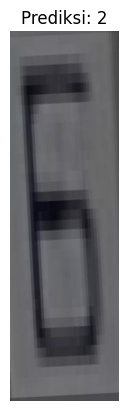

In [8]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Transformasi yang digunakan saat pengujian (harus sesuai dengan validation transform)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Sesuaikan ukuran untuk MobileNetV2
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisasi yang sama seperti saat training
])

# Load dan preprocess gambar untuk pengujian
img_path = f'{dataset_dir}/6/image_2356.jpg'  # Ubah ke path gambar yang diinginkan
img = Image.open(img_path)

# Terapkan transformasi dan tambahkan dimensi batch
img = test_transform(img).unsqueeze(0)  # Tambahkan dimensi batch
img = img.to(device)  # Pindahkan gambar ke device (GPU/CPU)

# Prediksi gambar menggunakan model MobileNetV2
mobile_net_base_model.eval()  # Set model ke mode evaluasi
with torch.no_grad():  # Nonaktifkan gradien untuk inferensi
    predictions = mobile_net_base_model(img)
    _, predicted_class_idx = torch.max(predictions, 1)  # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_idx = predicted_class_idx.item()

# Dapatkan label kelas dari dataset pelatihan
labels = train_loader.dataset.dataset.classes  # Ambil daftar label dari dataset pelatihan

# Ambil label yang sesuai dengan indeks prediksi
predicted_label = labels[predicted_class_idx]

# Tampilkan hasil prediksi
print(f"Hasil prediksi: {predicted_label}")

# Tampilkan gambar dengan hasil prediksi
plt.imshow(Image.open(img_path))
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')  # Menghilangkan sumbu pada gambar
plt.show()

# InceptionV3

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load model InceptionV3 dari torchvision dengan pretrained weights
InceptionV3_base_model = models.inception_v3(pretrained=True)

# Modifikasi auxiliary classifier (AuxLogits)
num_aux_ftrs = InceptionV3_base_model.AuxLogits.fc.in_features
InceptionV3_base_model.AuxLogits.fc = nn.Sequential(
    nn.Linear(num_aux_ftrs, 128),  # Linear layer dengan output 128
    nn.ReLU(),  # Aktivasi ReLU
    nn.Linear(128, len(train_loader.dataset.dataset.classes))  # Output sesuai jumlah kelas
)

# Modifikasi fully connected layer utama
num_ftrs = InceptionV3_base_model.fc.in_features
InceptionV3_base_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),  # Linear layer dengan output 128
    nn.ReLU(),  # Aktivasi ReLU
    nn.Linear(128, len(train_loader.dataset.dataset.classes))  # Output sesuai jumlah kelas
)

# Bekukan semua parameter di InceptionV3_base_model kecuali classifier (AuxLogits dan fc)
for param in InceptionV3_base_model.parameters():
    param.requires_grad = False

# Hanya aktifkan gradien untuk auxiliary classifier dan fully connected layer utama
for param in InceptionV3_base_model.AuxLogits.parameters():
    param.requires_grad = True

for param in InceptionV3_base_model.fc.parameters():
    param.requires_grad = True

# Gunakan GPU jika tersedia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
InceptionV3_base_model = InceptionV3_base_model.to(device)

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mencakup softmax secara internal
optimizer = optim.Adam(list(InceptionV3_base_model.AuxLogits.parameters()) + list(InceptionV3_base_model.fc.parameters()), lr=0.001)

# Print konfigurasi model untuk memastikan semuanya sudah benar
print(f"Model dikonfigurasi dengan {len(train_loader.dataset.dataset.classes)} output classes.")

c:\Users\whisn\anaconda3\envs\ocr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\whisn/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:26<00:00, 4.19MB/s] 


Model dikonfigurasi dengan 11 output classes.


In [12]:
import torch
from torchvision import transforms

# Mulai pelatihan
epochs = 50
best_accuracy = 0.0  # Untuk menyimpan akurasi terbaik
model_save_path = "inception.pth" 

# Resize transform untuk menyesuaikan ukuran input
resize_transform = transforms.Resize((299, 299))
total_training_start_time = time.time()

for epoch in range(epochs):
    InceptionV3_base_model.train()  # Set model ke mode pelatihan
    running_loss = 0.0
    running_accuracy = 0.0

    # Looping melalui data training
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradien

            # Resize input jika ukuran gambar tidak sesuai (299x299 untuk InceptionV3)
            if inputs.shape[-2] < 299 or inputs.shape[-1] < 299:
                inputs = resize_transform(inputs)

            # Forward pass: InceptionV3 mengembalikan dua output (utama dan auxiliary)
            outputs, aux_outputs = InceptionV3_base_model(inputs)

            # Hitung loss untuk output utama dan auxiliary
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2  # Auxiliary loss dengan faktor 0.4

            # Backward pass dan optimisasi
            loss.backward()
            optimizer.step()

            # Update running loss dan akurasi
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_accuracy += torch.sum(preds == labels.data)

            # Update progress bar dengan loss per batch
            tepoch.set_postfix(loss=loss.item())

    # Hitung loss dan akurasi rata-rata per epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy.double() / len(train_loader.dataset)

    # Cetak hasil pelatihan untuk setiap epoch
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    # Menyimpan model jika akurasi saat ini lebih baik dari akurasi terbaik sebelumnya
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(mobile_net_base_model.state_dict(), model_save_path)
        print(f"Model saved with accuracy: {best_accuracy:.4f}")
        
    # Evaluasi (validasi) model pada akhir setiap epoch
    InceptionV3_base_model.eval()  # Set model ke mode evaluasi
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Matikan gradien selama validasi
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Resize input jika ukuran gambar tidak sesuai (299x299 untuk InceptionV3)
            if val_inputs.shape[-2] < 299 or val_inputs.shape[-1] < 299:
                val_inputs = resize_transform(val_inputs)

            # Forward pass hanya menggunakan output utama (tanpa auxiliary)
            val_outputs = InceptionV3_base_model(val_inputs)
            val_outputs = val_outputs[0] if isinstance(val_outputs, tuple) else val_outputs  # Ambil output utama

            # Cek ukuran output dan target sebelum menghitung loss
            if val_outputs.size(0) == val_labels.size(0):
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_inputs.size(0)
                _, val_preds = torch.max(val_outputs, 1)
                val_running_accuracy += torch.sum(val_preds == val_labels.data)
            else:
                print(f"Size mismatch: output {val_outputs.size(0)}, target {val_labels.size(0)}")

    # Hitung rata-rata loss dan akurasi untuk validasi
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_running_accuracy.double() / len(val_loader.dataset)

    # Cetak hasil validasi
    print(f"Validation - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}")

    # Menyimpan model jika akurasi validasi terbaik ditemukan
    if val_epoch_accuracy > best_accuracy:
        best_accuracy = val_epoch_accuracy
        torch.save(InceptionV3_base_model.state_dict(), 'inception.pth')
        print(f"New best model saved with accuracy: {best_accuracy:.4f}")
        
# Menghitung total waktu pelatihan
total_training_time = time.time() - total_training_start_time
# Menampilkan total waktu setelah training selesai
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50: 100%|██████████| 62/62 [00:08<00:00,  7.38batch/s, loss=0.681]


Epoch 1/50 - Loss: 0.8064, Accuracy: 0.7150
Model saved with accuracy: 0.7150
Validation - Loss: 0.8038, Accuracy: 0.7313
New best model saved with accuracy: 0.7313


Epoch 2/50: 100%|██████████| 62/62 [00:09<00:00,  6.81batch/s, loss=1.09] 


Epoch 2/50 - Loss: 0.7938, Accuracy: 0.7332
Model saved with accuracy: 0.7332
Validation - Loss: 0.7601, Accuracy: 0.7515
New best model saved with accuracy: 0.7515


Epoch 3/50: 100%|██████████| 62/62 [00:08<00:00,  7.56batch/s, loss=0.658]


Epoch 3/50 - Loss: 0.8468, Accuracy: 0.7115
Validation - Loss: 0.7612, Accuracy: 0.7495


Epoch 4/50: 100%|██████████| 62/62 [00:08<00:00,  7.74batch/s, loss=1.13] 


Epoch 4/50 - Loss: 0.8425, Accuracy: 0.7054
Validation - Loss: 0.8104, Accuracy: 0.7313


Epoch 5/50: 100%|██████████| 62/62 [00:07<00:00,  7.89batch/s, loss=0.808]


Epoch 5/50 - Loss: 0.8656, Accuracy: 0.6968
Validation - Loss: 0.8243, Accuracy: 0.7111


Epoch 6/50: 100%|██████████| 62/62 [00:08<00:00,  7.25batch/s, loss=0.7]  


Epoch 6/50 - Loss: 0.8352, Accuracy: 0.7059
Validation - Loss: 0.8256, Accuracy: 0.7374


Epoch 7/50: 100%|██████████| 62/62 [00:08<00:00,  7.61batch/s, loss=0.726]


Epoch 7/50 - Loss: 0.8116, Accuracy: 0.7110
Validation - Loss: 0.7730, Accuracy: 0.7434


Epoch 8/50: 100%|██████████| 62/62 [00:08<00:00,  7.52batch/s, loss=0.656]


Epoch 8/50 - Loss: 0.7780, Accuracy: 0.7251
Validation - Loss: 0.7985, Accuracy: 0.7333


Epoch 9/50: 100%|██████████| 62/62 [00:08<00:00,  7.53batch/s, loss=0.844]


Epoch 9/50 - Loss: 0.8494, Accuracy: 0.7049
Validation - Loss: 0.7917, Accuracy: 0.7374


Epoch 10/50: 100%|██████████| 62/62 [00:08<00:00,  7.36batch/s, loss=0.985]


Epoch 10/50 - Loss: 0.8100, Accuracy: 0.7170
Validation - Loss: 0.7763, Accuracy: 0.7434


Epoch 11/50: 100%|██████████| 62/62 [00:08<00:00,  7.71batch/s, loss=0.534]


Epoch 11/50 - Loss: 0.8184, Accuracy: 0.7120
Validation - Loss: 0.7842, Accuracy: 0.7313


Epoch 12/50: 100%|██████████| 62/62 [00:08<00:00,  7.37batch/s, loss=0.613]


Epoch 12/50 - Loss: 0.8645, Accuracy: 0.6963
Validation - Loss: 0.7908, Accuracy: 0.7414


Epoch 13/50: 100%|██████████| 62/62 [00:08<00:00,  7.59batch/s, loss=0.981]


Epoch 13/50 - Loss: 0.8151, Accuracy: 0.7145
Validation - Loss: 0.7661, Accuracy: 0.7374


Epoch 14/50: 100%|██████████| 62/62 [00:08<00:00,  7.11batch/s, loss=1.03] 


Epoch 14/50 - Loss: 0.7933, Accuracy: 0.7281
Validation - Loss: 0.7892, Accuracy: 0.7253


Epoch 15/50: 100%|██████████| 62/62 [00:08<00:00,  7.36batch/s, loss=1]    


Epoch 15/50 - Loss: 0.8064, Accuracy: 0.7297
Validation - Loss: 0.7893, Accuracy: 0.7172


Epoch 16/50: 100%|██████████| 62/62 [00:08<00:00,  7.35batch/s, loss=0.781]


Epoch 16/50 - Loss: 0.7847, Accuracy: 0.7297
Validation - Loss: 0.7598, Accuracy: 0.7455


Epoch 17/50: 100%|██████████| 62/62 [00:07<00:00,  8.11batch/s, loss=1.01] 


Epoch 17/50 - Loss: 0.7996, Accuracy: 0.7206
Validation - Loss: 0.7625, Accuracy: 0.7374


Epoch 18/50: 100%|██████████| 62/62 [00:08<00:00,  7.06batch/s, loss=0.925]


Epoch 18/50 - Loss: 0.7658, Accuracy: 0.7317
Validation - Loss: 0.7299, Accuracy: 0.7636
New best model saved with accuracy: 0.7636


Epoch 19/50: 100%|██████████| 62/62 [00:08<00:00,  7.39batch/s, loss=0.86] 


Epoch 19/50 - Loss: 0.8108, Accuracy: 0.7191
Validation - Loss: 0.7716, Accuracy: 0.7414


Epoch 20/50: 100%|██████████| 62/62 [00:08<00:00,  7.53batch/s, loss=1.26] 


Epoch 20/50 - Loss: 0.7961, Accuracy: 0.7287
Validation - Loss: 0.7849, Accuracy: 0.7293


Epoch 21/50: 100%|██████████| 62/62 [00:08<00:00,  7.20batch/s, loss=1.16] 


Epoch 21/50 - Loss: 0.7916, Accuracy: 0.7266
Validation - Loss: 0.8590, Accuracy: 0.7172


Epoch 22/50: 100%|██████████| 62/62 [00:08<00:00,  6.91batch/s, loss=0.937]


Epoch 22/50 - Loss: 0.7684, Accuracy: 0.7317
Validation - Loss: 0.8053, Accuracy: 0.7273


Epoch 23/50: 100%|██████████| 62/62 [00:08<00:00,  7.25batch/s, loss=0.771]


Epoch 23/50 - Loss: 0.8070, Accuracy: 0.7191
Validation - Loss: 0.7512, Accuracy: 0.7394


Epoch 24/50: 100%|██████████| 62/62 [00:09<00:00,  6.86batch/s, loss=0.619]


Epoch 24/50 - Loss: 0.7929, Accuracy: 0.7327
Validation - Loss: 0.7860, Accuracy: 0.7434


Epoch 25/50: 100%|██████████| 62/62 [00:08<00:00,  7.61batch/s, loss=0.678]


Epoch 25/50 - Loss: 0.7908, Accuracy: 0.7352
Validation - Loss: 0.7397, Accuracy: 0.7475


Epoch 26/50: 100%|██████████| 62/62 [00:08<00:00,  7.44batch/s, loss=1.08] 


Epoch 26/50 - Loss: 0.7754, Accuracy: 0.7347
Validation - Loss: 0.7539, Accuracy: 0.7758
New best model saved with accuracy: 0.7758


Epoch 27/50: 100%|██████████| 62/62 [00:08<00:00,  7.68batch/s, loss=0.736]


Epoch 27/50 - Loss: 0.7442, Accuracy: 0.7433
Validation - Loss: 0.7546, Accuracy: 0.7495


Epoch 28/50: 100%|██████████| 62/62 [00:08<00:00,  7.48batch/s, loss=0.514]


Epoch 28/50 - Loss: 0.7798, Accuracy: 0.7317
Validation - Loss: 0.7538, Accuracy: 0.7434


Epoch 29/50: 100%|██████████| 62/62 [00:08<00:00,  7.54batch/s, loss=0.75] 


Epoch 29/50 - Loss: 0.8035, Accuracy: 0.7155
Validation - Loss: 0.8201, Accuracy: 0.7293


Epoch 30/50: 100%|██████████| 62/62 [00:08<00:00,  7.57batch/s, loss=0.569]


Epoch 30/50 - Loss: 0.7173, Accuracy: 0.7615
Validation - Loss: 0.8113, Accuracy: 0.7172


Epoch 31/50: 100%|██████████| 62/62 [00:08<00:00,  7.06batch/s, loss=0.567]


Epoch 31/50 - Loss: 0.7560, Accuracy: 0.7372
Validation - Loss: 0.7616, Accuracy: 0.7313


Epoch 32/50: 100%|██████████| 62/62 [00:08<00:00,  7.17batch/s, loss=0.926]


Epoch 32/50 - Loss: 0.8021, Accuracy: 0.7246
Validation - Loss: 0.7702, Accuracy: 0.7313


Epoch 33/50: 100%|██████████| 62/62 [00:08<00:00,  7.11batch/s, loss=0.728]


Epoch 33/50 - Loss: 0.7554, Accuracy: 0.7418
Validation - Loss: 0.7663, Accuracy: 0.7394


Epoch 34/50: 100%|██████████| 62/62 [00:09<00:00,  6.21batch/s, loss=0.743]


Epoch 34/50 - Loss: 0.7684, Accuracy: 0.7388
Validation - Loss: 0.7632, Accuracy: 0.7515


Epoch 35/50: 100%|██████████| 62/62 [00:08<00:00,  7.26batch/s, loss=0.362]


Epoch 35/50 - Loss: 0.7632, Accuracy: 0.7322
Validation - Loss: 0.8114, Accuracy: 0.7172


Epoch 36/50: 100%|██████████| 62/62 [00:08<00:00,  7.31batch/s, loss=0.697]


Epoch 36/50 - Loss: 0.7597, Accuracy: 0.7453
Validation - Loss: 0.7519, Accuracy: 0.7556


Epoch 37/50: 100%|██████████| 62/62 [00:08<00:00,  7.32batch/s, loss=0.499]


Epoch 37/50 - Loss: 0.7564, Accuracy: 0.7484
Validation - Loss: 0.7901, Accuracy: 0.7394


Epoch 38/50: 100%|██████████| 62/62 [00:08<00:00,  7.08batch/s, loss=0.712]


Epoch 38/50 - Loss: 0.7568, Accuracy: 0.7423
Validation - Loss: 0.7942, Accuracy: 0.7253


Epoch 39/50: 100%|██████████| 62/62 [00:08<00:00,  7.31batch/s, loss=0.828]


Epoch 39/50 - Loss: 0.7151, Accuracy: 0.7580
Validation - Loss: 0.7623, Accuracy: 0.7495


Epoch 40/50: 100%|██████████| 62/62 [00:08<00:00,  7.25batch/s, loss=0.649]


Epoch 40/50 - Loss: 0.7288, Accuracy: 0.7549
Validation - Loss: 0.7412, Accuracy: 0.7495


Epoch 41/50: 100%|██████████| 62/62 [00:09<00:00,  6.46batch/s, loss=0.828]


Epoch 41/50 - Loss: 0.7294, Accuracy: 0.7448
Validation - Loss: 0.7971, Accuracy: 0.7333


Epoch 42/50: 100%|██████████| 62/62 [00:09<00:00,  6.74batch/s, loss=1.19] 


Epoch 42/50 - Loss: 0.7591, Accuracy: 0.7367
Validation - Loss: 0.7492, Accuracy: 0.7535


Epoch 43/50: 100%|██████████| 62/62 [00:09<00:00,  6.58batch/s, loss=0.746]


Epoch 43/50 - Loss: 0.7255, Accuracy: 0.7494
Validation - Loss: 0.7505, Accuracy: 0.7394


Epoch 44/50: 100%|██████████| 62/62 [00:09<00:00,  6.57batch/s, loss=0.583]


Epoch 44/50 - Loss: 0.7248, Accuracy: 0.7438
Validation - Loss: 0.7594, Accuracy: 0.7515


Epoch 45/50: 100%|██████████| 62/62 [00:08<00:00,  6.95batch/s, loss=0.48] 


Epoch 45/50 - Loss: 0.7354, Accuracy: 0.7428
Validation - Loss: 0.7853, Accuracy: 0.7434


Epoch 46/50: 100%|██████████| 62/62 [00:08<00:00,  7.07batch/s, loss=0.759]


Epoch 46/50 - Loss: 0.7453, Accuracy: 0.7468
Validation - Loss: 0.7675, Accuracy: 0.7434


Epoch 47/50: 100%|██████████| 62/62 [00:08<00:00,  7.08batch/s, loss=0.511]


Epoch 47/50 - Loss: 0.7501, Accuracy: 0.7377
Validation - Loss: 0.7735, Accuracy: 0.7434


Epoch 48/50: 100%|██████████| 62/62 [00:08<00:00,  7.42batch/s, loss=0.871]


Epoch 48/50 - Loss: 0.7208, Accuracy: 0.7484
Validation - Loss: 0.7676, Accuracy: 0.7333


Epoch 49/50: 100%|██████████| 62/62 [00:08<00:00,  7.38batch/s, loss=0.789]


Epoch 49/50 - Loss: 0.6775, Accuracy: 0.7716
Validation - Loss: 0.7530, Accuracy: 0.7434


Epoch 50/50: 100%|██████████| 62/62 [00:08<00:00,  7.55batch/s, loss=0.75] 


Epoch 50/50 - Loss: 0.7663, Accuracy: 0.7297
Validation - Loss: 0.7897, Accuracy: 0.7111
Total training time: 529.09 seconds


Hasil prediksi: 2


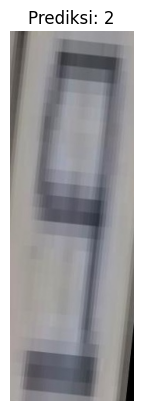

In [13]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Transformasi yang digunakan saat pengujian (harus sesuai dengan validation transform)
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Sesuaikan ukuran untuk InceptionV3 (299x299)
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisasi sesuai training
])

# Load dan preprocess gambar untuk pengujian
img_path = f'{dataset_dir}/9/image_338.jpg'  # Ubah ke path gambar yang diinginkan
img = Image.open(img_path)

# Terapkan transformasi dan tambahkan dimensi batch
img = test_transform(img).unsqueeze(0)  # Tambahkan dimensi batch (1, C, H, W)
img = img.to(device)  # Pindahkan gambar ke device (GPU/CPU)

# Prediksi gambar menggunakan model InceptionV3
InceptionV3_base_model.eval()  # Set model ke mode evaluasi
with torch.no_grad():  # Nonaktifkan gradien untuk inferensi
    outputs = InceptionV3_base_model(img)

    # Jika output adalah tuple, ambil hanya output utama
    predictions = outputs[0] if isinstance(outputs, tuple) else outputs

    # Ambil kelas dengan probabilitas tertinggi
    _, predicted_class_idx = torch.max(predictions, 1)
    predicted_class_idx = predicted_class_idx.item()

# Dapatkan label kelas dari dataset pelatihan
labels = train_loader.dataset.dataset.classes  # Ambil daftar label dari dataset pelatihan

# Ambil label yang sesuai dengan indeks prediksi
predicted_label = labels[predicted_class_idx]

# Tampilkan hasil prediksi
print(f"Hasil prediksi: {predicted_label}")

# Tampilkan gambar dengan hasil prediksi
plt.imshow(Image.open(img_path))  # Muat ulang gambar untuk ditampilkan
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')  # Hilangkan sumbu untuk tampilan lebih rapi
plt.show()

# VGG16

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pretrained VGG16 model from torchvision
vgg16 = models.vgg16(pretrained=True)

# Jumlah neuron di hidden layer classifier dan jumlah kelas
hidden_units = 128
num_classes = len(train_loader.dataset.dataset.classes)  # Dapatkan jumlah kelas dari dataset

# Modifikasi fully connected layer (classifier) di VGG16
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(4096, hidden_units),  # 4096 adalah input size untuk layer fc6 pada VGG16
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),  # Tambahkan dropout untuk regularisasi
    nn.Linear(hidden_units, num_classes)  # Output layer sesuai dengan jumlah kelas
)

# Fine-tuning hanya sebagian dari layer convolutional (misalnya, buka blok terakhir)
for param in vgg16.features[:10].parameters():
    param.requires_grad = False  # Bekukan layer awal saja

# Hanya aktifkan gradien untuk classifier dan beberapa layer convolutional terakhir
for param in vgg16.features[10:].parameters():
    param.requires_grad = True  # Buka blok terakhir untuk fine-tuning

for param in vgg16.classifier.parameters():
    param.requires_grad = True  # Pastikan classifier dilatih

# Gunakan GPU jika tersedia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mencakup LogSoftmax secara internal
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)  # Gunakan learning rate yang lebih rendah

# Tambahkan scheduler untuk menurunkan learning rate secara bertahap
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Print konfigurasi model untuk memastikan semuanya sudah benar
print(f"Model dikonfigurasi dengan {num_classes} output classes.")

c:\Users\whisn\anaconda3\envs\ocr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\whisn/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [02:09<00:00, 4.28MB/s] 


Model dikonfigurasi dengan 11 output classes.


In [15]:
import time
from tqdm import tqdm
import torch
import torch.optim as optim
from torchvision import transforms

# Transformasi untuk memastikan ukuran input sesuai dengan VGG16
resize_transform = transforms.Resize((224, 224))

# Scheduler untuk menurunkan learning rate secara bertahap (opsional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Mulai pelatihan
epochs = 50
best_accuracy = 0.0  # Untuk menyimpan akurasi terbaik
model_save_path = "vgg16.pth" 
# Mulai total timer
total_training_start_time = time.time()

for epoch in range(epochs):
    # Pelatihan
    vgg16.train()  # Set model ke mode pelatihan
    running_loss = 0.0
    running_accuracy = 0.0
    start_time = time.time()  # Untuk menghitung waktu per epoch

    # Looping data training
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            # Resize input jika ukuran gambar tidak sesuai (224x224 untuk VGG16)
            if inputs.shape[-2] != 224 or inputs.shape[-1] != 224:
                inputs = resize_transform(inputs)

            optimizer.zero_grad()  # Reset gradien
            outputs = vgg16(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Hitung loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameter

            # Update running loss dan akurasi
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_accuracy += torch.sum(preds == labels.data)

            # Update progress bar dengan current loss
            tepoch.set_postfix(loss=loss.item())

    # Rata-rata loss dan akurasi per epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy.double() / len(train_loader.dataset)

    # Tampilkan hasil pelatihan per epoch
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {elapsed_time:.2f}s")

    # Validasi
    vgg16.eval()  # Set model ke mode evaluasi
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Matikan gradien selama validasi
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Resize input jika ukuran gambar tidak sesuai (224x224 untuk VGG16)
            if val_inputs.shape[-2] != 224 or val_inputs.shape[-1] != 224:
                val_inputs = resize_transform(val_inputs)

            val_outputs = vgg16(val_inputs)  # Forward pass

            val_loss = criterion(val_outputs, val_labels)  # Hitung loss
            val_running_loss += val_loss.item() * val_inputs.size(0)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_accuracy += torch.sum(val_preds == val_labels.data)

    # Rata-rata loss dan akurasi untuk validation
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_running_accuracy.double() / len(val_loader.dataset)

    print(f"Validation - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}")
    # Menampilkan hasil pelatihan per epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {epoch_time:.2}")
    # Menyimpan model jika akurasi saat ini lebih baik dari akurasi terbaik sebelumnya
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(mobile_net_base_model.state_dict(), model_save_path)
        print(f"Model saved with accuracy: {best_accuracy:.4f}")

    # Update scheduler (opsional)
    scheduler.step()
    
# Menghitung total waktu pelatihan
total_training_time = time.time() - total_training_start_time
# Menampilkan total waktu setelah training selesai
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50: 100%|██████████| 62/62 [00:35<00:00,  1.74batch/s, loss=0.172]


Epoch 1/50, Loss: 1.3021, Accuracy: 0.5528, Time: 35.65s
Validation - Loss: 0.2974, Accuracy: 0.8646
Epoch 1/50, Loss: 1.3021, Accuracy: 0.5528, Time: 7.7
Model saved with accuracy: 0.5528


Epoch 2/50: 100%|██████████| 62/62 [00:22<00:00,  2.75batch/s, loss=0.00699]


Epoch 2/50, Loss: 0.1945, Accuracy: 0.9434, Time: 22.55s
Validation - Loss: 0.0491, Accuracy: 0.9899
Epoch 2/50, Loss: 0.1945, Accuracy: 0.9434, Time: 7.7
Model saved with accuracy: 0.9434


Epoch 3/50: 100%|██████████| 62/62 [00:22<00:00,  2.73batch/s, loss=0.0121] 


Epoch 3/50, Loss: 0.0845, Accuracy: 0.9838, Time: 22.74s
Validation - Loss: 0.0435, Accuracy: 0.9919
Epoch 3/50, Loss: 0.0845, Accuracy: 0.9838, Time: 7.7
Model saved with accuracy: 0.9838


Epoch 4/50: 100%|██████████| 62/62 [00:23<00:00,  2.68batch/s, loss=0.000749]


Epoch 4/50, Loss: 0.0360, Accuracy: 0.9919, Time: 23.10s
Validation - Loss: 0.0542, Accuracy: 0.9859
Epoch 4/50, Loss: 0.0360, Accuracy: 0.9919, Time: 7.7
Model saved with accuracy: 0.9919


Epoch 5/50: 100%|██████████| 62/62 [00:23<00:00,  2.69batch/s, loss=0.00467] 


Epoch 5/50, Loss: 0.0362, Accuracy: 0.9874, Time: 23.04s
Validation - Loss: 0.0220, Accuracy: 0.9919
Epoch 5/50, Loss: 0.0362, Accuracy: 0.9874, Time: 7.7


Epoch 6/50: 100%|██████████| 62/62 [00:30<00:00,  2.03batch/s, loss=0.00825] 


Epoch 6/50, Loss: 0.0259, Accuracy: 0.9949, Time: 30.62s
Validation - Loss: 0.0297, Accuracy: 0.9919
Epoch 6/50, Loss: 0.0259, Accuracy: 0.9949, Time: 7.7
Model saved with accuracy: 0.9949


Epoch 7/50: 100%|██████████| 62/62 [00:30<00:00,  2.00batch/s, loss=0.0792]  


Epoch 7/50, Loss: 0.0414, Accuracy: 0.9899, Time: 30.95s
Validation - Loss: 0.0252, Accuracy: 0.9919
Epoch 7/50, Loss: 0.0414, Accuracy: 0.9899, Time: 7.7


Epoch 8/50: 100%|██████████| 62/62 [00:32<00:00,  1.91batch/s, loss=0.000781]


Epoch 8/50, Loss: 0.0111, Accuracy: 0.9980, Time: 32.51s
Validation - Loss: 0.0296, Accuracy: 0.9899
Epoch 8/50, Loss: 0.0111, Accuracy: 0.9980, Time: 7.7
Model saved with accuracy: 0.9980


Epoch 9/50: 100%|██████████| 62/62 [00:25<00:00,  2.40batch/s, loss=0.000681]


Epoch 9/50, Loss: 0.0086, Accuracy: 0.9980, Time: 25.88s
Validation - Loss: 0.0349, Accuracy: 0.9899
Epoch 9/50, Loss: 0.0086, Accuracy: 0.9980, Time: 7.7


Epoch 10/50: 100%|██████████| 62/62 [00:28<00:00,  2.18batch/s, loss=0.000101]


Epoch 10/50, Loss: 0.0079, Accuracy: 0.9990, Time: 28.45s
Validation - Loss: 0.0276, Accuracy: 0.9919
Epoch 10/50, Loss: 0.0079, Accuracy: 0.9990, Time: 7.7
Model saved with accuracy: 0.9990


Epoch 11/50: 100%|██████████| 62/62 [00:33<00:00,  1.86batch/s, loss=9.3e-5]  


Epoch 11/50, Loss: 0.0041, Accuracy: 0.9995, Time: 33.29s
Validation - Loss: 0.0278, Accuracy: 0.9899
Epoch 11/50, Loss: 0.0041, Accuracy: 0.9995, Time: 7.7
Model saved with accuracy: 0.9995


Epoch 12/50: 100%|██████████| 62/62 [00:30<00:00,  2.06batch/s, loss=0.000275]


Epoch 12/50, Loss: 0.0021, Accuracy: 0.9995, Time: 30.05s
Validation - Loss: 0.0292, Accuracy: 0.9899
Epoch 12/50, Loss: 0.0021, Accuracy: 0.9995, Time: 7.7


Epoch 13/50: 100%|██████████| 62/62 [00:26<00:00,  2.34batch/s, loss=0.000669]


Epoch 13/50, Loss: 0.0023, Accuracy: 0.9995, Time: 26.51s
Validation - Loss: 0.0292, Accuracy: 0.9899
Epoch 13/50, Loss: 0.0023, Accuracy: 0.9995, Time: 7.7


Epoch 14/50: 100%|██████████| 62/62 [00:33<00:00,  1.84batch/s, loss=0.000134]


Epoch 14/50, Loss: 0.0025, Accuracy: 0.9995, Time: 33.75s
Validation - Loss: 0.0293, Accuracy: 0.9919
Epoch 14/50, Loss: 0.0025, Accuracy: 0.9995, Time: 7.7


Epoch 15/50: 100%|██████████| 62/62 [00:37<00:00,  1.66batch/s, loss=0.000189]


Epoch 15/50, Loss: 0.0029, Accuracy: 0.9990, Time: 37.24s
Validation - Loss: 0.0285, Accuracy: 0.9919
Epoch 15/50, Loss: 0.0029, Accuracy: 0.9990, Time: 7.7


Epoch 16/50: 100%|██████████| 62/62 [00:37<00:00,  1.65batch/s, loss=7.65e-5] 


Epoch 16/50, Loss: 0.0017, Accuracy: 0.9995, Time: 37.59s
Validation - Loss: 0.0286, Accuracy: 0.9919
Epoch 16/50, Loss: 0.0017, Accuracy: 0.9995, Time: 7.7


Epoch 17/50: 100%|██████████| 62/62 [00:36<00:00,  1.68batch/s, loss=0.000218]


Epoch 17/50, Loss: 0.0021, Accuracy: 0.9995, Time: 36.85s
Validation - Loss: 0.0284, Accuracy: 0.9919
Epoch 17/50, Loss: 0.0021, Accuracy: 0.9995, Time: 7.7


Epoch 18/50: 100%|██████████| 62/62 [00:38<00:00,  1.60batch/s, loss=0.00467] 


Epoch 18/50, Loss: 0.0018, Accuracy: 0.9995, Time: 38.82s
Validation - Loss: 0.0278, Accuracy: 0.9919
Epoch 18/50, Loss: 0.0018, Accuracy: 0.9995, Time: 7.7


Epoch 19/50: 100%|██████████| 62/62 [00:38<00:00,  1.61batch/s, loss=0.000583]


Epoch 19/50, Loss: 0.0021, Accuracy: 0.9995, Time: 38.44s
Validation - Loss: 0.0273, Accuracy: 0.9919
Epoch 19/50, Loss: 0.0021, Accuracy: 0.9995, Time: 7.7


Epoch 20/50: 100%|██████████| 62/62 [00:37<00:00,  1.64batch/s, loss=4.74e-5] 


Epoch 20/50, Loss: 0.0033, Accuracy: 0.9995, Time: 37.82s
Validation - Loss: 0.0268, Accuracy: 0.9919
Epoch 20/50, Loss: 0.0033, Accuracy: 0.9995, Time: 7.7


Epoch 21/50: 100%|██████████| 62/62 [00:37<00:00,  1.67batch/s, loss=0.00149] 


Epoch 21/50, Loss: 0.0030, Accuracy: 0.9995, Time: 37.17s
Validation - Loss: 0.0265, Accuracy: 0.9919
Epoch 21/50, Loss: 0.0030, Accuracy: 0.9995, Time: 7.7


Epoch 22/50: 100%|██████████| 62/62 [00:38<00:00,  1.62batch/s, loss=6.19e-5] 


Epoch 22/50, Loss: 0.0015, Accuracy: 1.0000, Time: 38.17s
Validation - Loss: 0.0265, Accuracy: 0.9919
Epoch 22/50, Loss: 0.0015, Accuracy: 1.0000, Time: 7.7
Model saved with accuracy: 1.0000


Epoch 23/50: 100%|██████████| 62/62 [00:39<00:00,  1.58batch/s, loss=0.000236]


Epoch 23/50, Loss: 0.0021, Accuracy: 0.9995, Time: 39.17s
Validation - Loss: 0.0265, Accuracy: 0.9919
Epoch 23/50, Loss: 0.0021, Accuracy: 0.9995, Time: 7.7


Epoch 24/50: 100%|██████████| 62/62 [00:37<00:00,  1.64batch/s, loss=8.81e-6] 


Epoch 24/50, Loss: 0.0035, Accuracy: 0.9990, Time: 37.90s
Validation - Loss: 0.0265, Accuracy: 0.9919
Epoch 24/50, Loss: 0.0035, Accuracy: 0.9990, Time: 7.7


Epoch 25/50: 100%|██████████| 62/62 [00:30<00:00,  2.04batch/s, loss=0.0663]  


Epoch 25/50, Loss: 0.0023, Accuracy: 0.9995, Time: 30.37s
Validation - Loss: 0.0266, Accuracy: 0.9919
Epoch 25/50, Loss: 0.0023, Accuracy: 0.9995, Time: 7.7


Epoch 26/50: 100%|██████████| 62/62 [00:23<00:00,  2.67batch/s, loss=0.000289]


Epoch 26/50, Loss: 0.0044, Accuracy: 0.9990, Time: 23.23s
Validation - Loss: 0.0264, Accuracy: 0.9919
Epoch 26/50, Loss: 0.0044, Accuracy: 0.9990, Time: 7.7


Epoch 27/50: 100%|██████████| 62/62 [00:23<00:00,  2.69batch/s, loss=0.000183]


Epoch 27/50, Loss: 0.0023, Accuracy: 0.9995, Time: 23.02s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 27/50, Loss: 0.0023, Accuracy: 0.9995, Time: 7.7


Epoch 28/50: 100%|██████████| 62/62 [00:36<00:00,  1.69batch/s, loss=8.84e-5] 


Epoch 28/50, Loss: 0.0011, Accuracy: 1.0000, Time: 36.63s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 28/50, Loss: 0.0011, Accuracy: 1.0000, Time: 7.7


Epoch 29/50: 100%|██████████| 62/62 [00:28<00:00,  2.19batch/s, loss=0.00026] 


Epoch 29/50, Loss: 0.0045, Accuracy: 0.9995, Time: 28.36s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 29/50, Loss: 0.0045, Accuracy: 0.9995, Time: 7.7


Epoch 30/50: 100%|██████████| 62/62 [00:23<00:00,  2.67batch/s, loss=0.022]   


Epoch 30/50, Loss: 0.0022, Accuracy: 0.9995, Time: 23.24s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 30/50, Loss: 0.0022, Accuracy: 0.9995, Time: 7.7


Epoch 31/50: 100%|██████████| 62/62 [00:23<00:00,  2.64batch/s, loss=0.00019] 


Epoch 31/50, Loss: 0.0023, Accuracy: 0.9990, Time: 23.53s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 31/50, Loss: 0.0023, Accuracy: 0.9990, Time: 7.7


Epoch 32/50: 100%|██████████| 62/62 [00:22<00:00,  2.74batch/s, loss=7.53e-5] 


Epoch 32/50, Loss: 0.0014, Accuracy: 1.0000, Time: 22.65s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 32/50, Loss: 0.0014, Accuracy: 1.0000, Time: 7.7


Epoch 33/50: 100%|██████████| 62/62 [00:22<00:00,  2.79batch/s, loss=0.0215]  


Epoch 33/50, Loss: 0.0047, Accuracy: 0.9990, Time: 22.20s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 33/50, Loss: 0.0047, Accuracy: 0.9990, Time: 7.7


Epoch 34/50: 100%|██████████| 62/62 [00:22<00:00,  2.80batch/s, loss=0.00776] 


Epoch 34/50, Loss: 0.0027, Accuracy: 0.9990, Time: 22.12s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 34/50, Loss: 0.0027, Accuracy: 0.9990, Time: 7.7


Epoch 35/50: 100%|██████████| 62/62 [00:21<00:00,  2.82batch/s, loss=0.00196] 


Epoch 35/50, Loss: 0.0020, Accuracy: 0.9995, Time: 21.96s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 35/50, Loss: 0.0020, Accuracy: 0.9995, Time: 7.7


Epoch 36/50: 100%|██████████| 62/62 [00:21<00:00,  2.83batch/s, loss=0.000568]


Epoch 36/50, Loss: 0.0031, Accuracy: 0.9990, Time: 21.94s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 36/50, Loss: 0.0031, Accuracy: 0.9990, Time: 7.7


Epoch 37/50: 100%|██████████| 62/62 [00:21<00:00,  2.84batch/s, loss=0.000262]


Epoch 37/50, Loss: 0.0013, Accuracy: 0.9995, Time: 21.83s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 37/50, Loss: 0.0013, Accuracy: 0.9995, Time: 7.7


Epoch 38/50: 100%|██████████| 62/62 [00:22<00:00,  2.81batch/s, loss=2.26e-5] 


Epoch 38/50, Loss: 0.0019, Accuracy: 0.9995, Time: 22.05s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 38/50, Loss: 0.0019, Accuracy: 0.9995, Time: 7.7


Epoch 39/50: 100%|██████████| 62/62 [00:21<00:00,  2.85batch/s, loss=0.00788] 


Epoch 39/50, Loss: 0.0022, Accuracy: 0.9995, Time: 21.77s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 39/50, Loss: 0.0022, Accuracy: 0.9995, Time: 7.7


Epoch 40/50: 100%|██████████| 62/62 [00:21<00:00,  2.83batch/s, loss=0.000242]


Epoch 40/50, Loss: 0.0031, Accuracy: 0.9990, Time: 21.95s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 40/50, Loss: 0.0031, Accuracy: 0.9990, Time: 7.7


Epoch 41/50: 100%|██████████| 62/62 [00:22<00:00,  2.79batch/s, loss=0.000263]


Epoch 41/50, Loss: 0.0022, Accuracy: 0.9995, Time: 22.19s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 41/50, Loss: 0.0022, Accuracy: 0.9995, Time: 7.7


Epoch 42/50: 100%|██████████| 62/62 [00:21<00:00,  2.82batch/s, loss=0.00133] 


Epoch 42/50, Loss: 0.0030, Accuracy: 0.9995, Time: 21.99s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 42/50, Loss: 0.0030, Accuracy: 0.9995, Time: 7.7


Epoch 43/50: 100%|██████████| 62/62 [00:22<00:00,  2.80batch/s, loss=0.00022] 


Epoch 43/50, Loss: 0.0024, Accuracy: 0.9990, Time: 22.18s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 43/50, Loss: 0.0024, Accuracy: 0.9990, Time: 7.7


Epoch 44/50: 100%|██████████| 62/62 [00:22<00:00,  2.79batch/s, loss=0.000519]


Epoch 44/50, Loss: 0.0030, Accuracy: 0.9995, Time: 22.20s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 44/50, Loss: 0.0030, Accuracy: 0.9995, Time: 7.7


Epoch 45/50: 100%|██████████| 62/62 [00:22<00:00,  2.78batch/s, loss=6.89e-5] 


Epoch 45/50, Loss: 0.0017, Accuracy: 1.0000, Time: 22.32s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 45/50, Loss: 0.0017, Accuracy: 1.0000, Time: 7.7


Epoch 46/50: 100%|██████████| 62/62 [00:22<00:00,  2.80batch/s, loss=9.95e-5] 


Epoch 46/50, Loss: 0.0036, Accuracy: 0.9990, Time: 22.16s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 46/50, Loss: 0.0036, Accuracy: 0.9990, Time: 7.7


Epoch 47/50: 100%|██████████| 62/62 [00:21<00:00,  2.85batch/s, loss=7.21e-5] 


Epoch 47/50, Loss: 0.0019, Accuracy: 1.0000, Time: 21.75s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 47/50, Loss: 0.0019, Accuracy: 1.0000, Time: 7.7


Epoch 48/50: 100%|██████████| 62/62 [00:21<00:00,  2.84batch/s, loss=0.000348]


Epoch 48/50, Loss: 0.0018, Accuracy: 0.9995, Time: 21.84s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 48/50, Loss: 0.0018, Accuracy: 0.9995, Time: 7.7


Epoch 49/50: 100%|██████████| 62/62 [00:21<00:00,  2.82batch/s, loss=0.000139]


Epoch 49/50, Loss: 0.0020, Accuracy: 0.9995, Time: 21.97s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 49/50, Loss: 0.0020, Accuracy: 0.9995, Time: 7.7


Epoch 50/50: 100%|██████████| 62/62 [00:22<00:00,  2.80batch/s, loss=0.00112] 


Epoch 50/50, Loss: 0.0056, Accuracy: 0.9985, Time: 22.18s
Validation - Loss: 0.0263, Accuracy: 0.9919
Epoch 50/50, Loss: 0.0056, Accuracy: 0.9985, Time: 7.7
Total training time: 1593.29 seconds


Hasil prediksi: 6


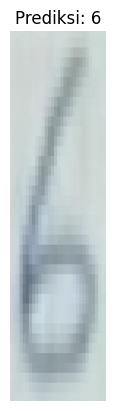

In [16]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Transformasi yang digunakan saat pengujian (harus sesuai dengan transformasi validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Sesuaikan ukuran untuk ResNet50 (224x224)
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisasi sesuai training
])

# Load dan preprocess gambar untuk pengujian
img_path = f'{dataset_dir}/6/image_3065.jpg'  # Ubah ke path gambar yang diinginkan
img = Image.open(img_path)

# Terapkan transformasi dan tambahkan dimensi batch
img = test_transform(img).unsqueeze(0)  # Tambahkan dimensi batch (1, C, H, W)
img = img.to(device)  # Pindahkan gambar ke device (GPU/CPU)

# Prediksi gambar menggunakan model ResNet50
vgg16.eval()  # Set model ke mode evaluasi
with torch.no_grad():  # Nonaktifkan gradien untuk inferensi
    predictions = vgg16(img)  # ResNet50 hanya mengembalikan satu output

    # Ambil kelas dengan probabilitas tertinggi
    _, predicted_class_idx = torch.max(predictions, 1)
    predicted_class_idx = predicted_class_idx.item()

# Dapatkan label kelas dari dataset pelatihan
labels = train_loader.dataset.dataset.classes  # Ambil daftar label dari dataset pelatihan

# Ambil label yang sesuai dengan indeks prediksi
predicted_label = labels[predicted_class_idx]

# Tampilkan hasil prediksi
print(f"Hasil prediksi: {predicted_label}")

# Tampilkan gambar dengan hasil prediksi
plt.imshow(Image.open(img_path))  # Muat ulang gambar untuk ditampilkan
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')  # Hilangkan sumbu untuk tampilan lebih rapi
plt.show()

#ResNet50

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load model ResNet50 dari torchvision dengan pretrained weights
resnet50 = models.resnet50(pretrained=True)

# Jumlah neuron di input layer fully connected dan jumlah kelas
num_features = resnet50.fc.in_features
num_classes = len(train_loader.dataset.dataset.classes)  # Dapatkan jumlah kelas dari dataset

# Modifikasi fully connected layer di ResNet50
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 128),  # Fully connected layer pertama
    nn.ReLU(inplace=True),         # Aktivasi ReLU
    nn.Linear(128, num_classes)    # Output sesuai dengan jumlah kelas
)

# Bekukan semua parameter di layer selain fully connected layer (fc)
for param in resnet50.parameters():
    param.requires_grad = False

# Aktifkan pelatihan hanya untuk fully connected layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

# Gunakan GPU jika tersedia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mencakup LogSoftmax secara internal
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

# Print konfigurasi model untuk memastikan semuanya sudah benar
print(f"Model dikonfigurasi dengan {num_classes} output classes.")

c:\Users\whisn\anaconda3\envs\ocr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\whisn/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:23<00:00, 4.30MB/s]


Model dikonfigurasi dengan 11 output classes.


In [18]:
import time
from tqdm import tqdm
import torch
from torchvision import transforms

# Transformasi untuk memastikan ukuran input sesuai dengan ResNet50 (224x224)
resize_transform = transforms.Resize((224, 224))

# Mulai pelatihan
epochs = 50
best_accuracy = 0.0  # Untuk menyimpan akurasi terbaik
model_save_path = "resnet50.pth"

total_training_start_time = time.time() 
for epoch in range(epochs):
    resnet50.train()  # Set m odel ke mode pelatihan
    running_loss = 0.0
    running_accuracy = 0.0
    start_time = time.time()

    # Looping melalui data training dengan progress bar
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{epochs}")
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            # Resize input jika ukuran gambar tidak sesuai (224x224 untuk ResNet50)
            if inputs.shape[-2] != 224 or inputs.shape[-1] != 224:
                inputs = resize_transform(inputs)

            optimizer.zero_grad()  # Reset gradien

            # Forward pass
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            # Backward pass dan optimisasi
            loss.backward()
            optimizer.step()

            # Update running loss dan akurasi
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_accuracy += torch.sum(preds == labels.data)

            # Update progress bar dengan current loss
            tepoch.set_postfix(loss=loss.item())

    # Hitung rata-rata loss dan akurasi per epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy.double() / len(train_loader.dataset)

    # Tampilkan hasil pelatihan untuk setiap epoch
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {elapsed_time:.2f}s")

    # Validasi model pada akhir setiap epoch
    resnet50.eval()  # Set model ke mode evaluasi
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Matikan gradien selama validasi
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Resize input jika ukuran gambar tidak sesuai (224x224 untuk ResNet50)
            if val_inputs.shape[-2] != 224 or val_inputs.shape[-1] != 224:
                val_inputs = resize_transform(val_inputs)

            # Forward pass untuk validasi
            val_outputs = resnet50(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_inputs.size(0)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_accuracy += torch.sum(val_preds == val_labels.data)

    # Hitung rata-rata loss dan akurasi untuk validation
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_running_accuracy.double() / len(val_loader.dataset)

    # Tampilkan hasil validasi
    print(f"Validation - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}")

        
    # Simpan model jika akurasi validasi terbaik ditemukan
    if val_epoch_accuracy > best_accuracy:
        best_accuracy = val_epoch_accuracy
        torch.save(resnet50.state_dict(), 'resnet50.pth')
        print(f"New best model saved with accuracy: {best_accuracy:.4f}")
        
# Menghitung total waktu pelatihan
total_training_time = time.time() - total_training_start_time
# Menampilkan total waktu setelah training selesai
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/50: 100%|██████████| 62/62 [00:09<00:00,  6.86batch/s, loss=1.73]


Epoch 1/50, Loss: 2.1183, Accuracy: 0.2986, Time: 9.04s
Validation - Loss: 1.7331, Accuracy: 0.4747
New best model saved with accuracy: 0.4747


Epoch 2/50: 100%|██████████| 62/62 [00:07<00:00,  7.88batch/s, loss=1.33]


Epoch 2/50, Loss: 1.5633, Accuracy: 0.4992, Time: 7.87s
Validation - Loss: 1.4180, Accuracy: 0.5333
New best model saved with accuracy: 0.5333


Epoch 3/50: 100%|██████████| 62/62 [00:07<00:00,  7.93batch/s, loss=1.17] 


Epoch 3/50, Loss: 1.3144, Accuracy: 0.5609, Time: 7.82s
Validation - Loss: 1.1771, Accuracy: 0.6202
New best model saved with accuracy: 0.6202


Epoch 4/50: 100%|██████████| 62/62 [00:07<00:00,  8.04batch/s, loss=0.941]


Epoch 4/50, Loss: 1.1829, Accuracy: 0.6018, Time: 7.71s
Validation - Loss: 1.1385, Accuracy: 0.6141


Epoch 5/50: 100%|██████████| 62/62 [00:07<00:00,  7.90batch/s, loss=1.24] 


Epoch 5/50, Loss: 1.0827, Accuracy: 0.6342, Time: 7.85s
Validation - Loss: 1.0173, Accuracy: 0.6646
New best model saved with accuracy: 0.6646


Epoch 6/50: 100%|██████████| 62/62 [00:07<00:00,  7.92batch/s, loss=1.08] 


Epoch 6/50, Loss: 0.9775, Accuracy: 0.6746, Time: 7.83s
Validation - Loss: 0.9941, Accuracy: 0.6606


Epoch 7/50: 100%|██████████| 62/62 [00:07<00:00,  8.09batch/s, loss=0.797]


Epoch 7/50, Loss: 0.9250, Accuracy: 0.6781, Time: 7.67s
Validation - Loss: 0.9556, Accuracy: 0.6788
New best model saved with accuracy: 0.6788


Epoch 8/50: 100%|██████████| 62/62 [00:07<00:00,  8.14batch/s, loss=0.799]


Epoch 8/50, Loss: 0.9230, Accuracy: 0.6923, Time: 7.62s
Validation - Loss: 0.9103, Accuracy: 0.6848
New best model saved with accuracy: 0.6848


Epoch 9/50: 100%|██████████| 62/62 [00:07<00:00,  8.05batch/s, loss=0.656]


Epoch 9/50, Loss: 0.8799, Accuracy: 0.6983, Time: 7.70s
Validation - Loss: 0.9566, Accuracy: 0.6848


Epoch 10/50: 100%|██████████| 62/62 [00:07<00:00,  8.24batch/s, loss=0.554]


Epoch 10/50, Loss: 0.8440, Accuracy: 0.7089, Time: 7.53s
Validation - Loss: 0.9295, Accuracy: 0.6808


Epoch 11/50: 100%|██████████| 62/62 [00:07<00:00,  8.07batch/s, loss=0.807]


Epoch 11/50, Loss: 0.8408, Accuracy: 0.7094, Time: 7.69s
Validation - Loss: 0.8421, Accuracy: 0.7253
New best model saved with accuracy: 0.7253


Epoch 12/50: 100%|██████████| 62/62 [00:07<00:00,  8.09batch/s, loss=0.345]


Epoch 12/50, Loss: 0.7701, Accuracy: 0.7352, Time: 7.66s
Validation - Loss: 0.8687, Accuracy: 0.6909


Epoch 13/50: 100%|██████████| 62/62 [00:07<00:00,  7.86batch/s, loss=0.786]


Epoch 13/50, Loss: 0.7135, Accuracy: 0.7630, Time: 7.89s
Validation - Loss: 0.8761, Accuracy: 0.7010


Epoch 14/50: 100%|██████████| 62/62 [00:07<00:00,  7.93batch/s, loss=0.533]


Epoch 14/50, Loss: 0.7123, Accuracy: 0.7615, Time: 7.82s
Validation - Loss: 0.8817, Accuracy: 0.6949


Epoch 15/50: 100%|██████████| 62/62 [00:07<00:00,  7.79batch/s, loss=0.658]


Epoch 15/50, Loss: 0.7229, Accuracy: 0.7544, Time: 7.96s
Validation - Loss: 0.8648, Accuracy: 0.7111


Epoch 16/50: 100%|██████████| 62/62 [00:07<00:00,  7.80batch/s, loss=0.769]


Epoch 16/50, Loss: 0.6742, Accuracy: 0.7797, Time: 7.95s
Validation - Loss: 0.8605, Accuracy: 0.7111


Epoch 17/50: 100%|██████████| 62/62 [00:07<00:00,  7.97batch/s, loss=0.533]


Epoch 17/50, Loss: 0.6840, Accuracy: 0.7595, Time: 7.78s
Validation - Loss: 0.8897, Accuracy: 0.7091


Epoch 18/50: 100%|██████████| 62/62 [00:07<00:00,  8.01batch/s, loss=0.847]


Epoch 18/50, Loss: 0.6802, Accuracy: 0.7564, Time: 7.75s
Validation - Loss: 0.8114, Accuracy: 0.7253


Epoch 19/50: 100%|██████████| 62/62 [00:07<00:00,  8.00batch/s, loss=0.798]


Epoch 19/50, Loss: 0.6701, Accuracy: 0.7746, Time: 7.75s
Validation - Loss: 0.9168, Accuracy: 0.7192


Epoch 20/50: 100%|██████████| 62/62 [00:07<00:00,  8.00batch/s, loss=0.593]


Epoch 20/50, Loss: 0.6547, Accuracy: 0.7787, Time: 7.75s
Validation - Loss: 0.8677, Accuracy: 0.7152


Epoch 21/50: 100%|██████████| 62/62 [00:07<00:00,  7.92batch/s, loss=0.88] 


Epoch 21/50, Loss: 0.6316, Accuracy: 0.7706, Time: 7.83s
Validation - Loss: 0.9180, Accuracy: 0.7030


Epoch 22/50: 100%|██████████| 62/62 [00:07<00:00,  7.96batch/s, loss=0.903]


Epoch 22/50, Loss: 0.6587, Accuracy: 0.7772, Time: 7.79s
Validation - Loss: 0.8450, Accuracy: 0.7131


Epoch 23/50: 100%|██████████| 62/62 [00:07<00:00,  7.90batch/s, loss=0.778]


Epoch 23/50, Loss: 0.5983, Accuracy: 0.7908, Time: 7.85s
Validation - Loss: 0.8539, Accuracy: 0.7293
New best model saved with accuracy: 0.7293


Epoch 24/50: 100%|██████████| 62/62 [00:07<00:00,  7.92batch/s, loss=0.735]


Epoch 24/50, Loss: 0.6223, Accuracy: 0.7767, Time: 7.83s
Validation - Loss: 0.7698, Accuracy: 0.7434
New best model saved with accuracy: 0.7434


Epoch 25/50: 100%|██████████| 62/62 [00:07<00:00,  7.88batch/s, loss=0.638]


Epoch 25/50, Loss: 0.6019, Accuracy: 0.7888, Time: 7.87s
Validation - Loss: 0.8116, Accuracy: 0.7232


Epoch 26/50: 100%|██████████| 62/62 [00:08<00:00,  7.69batch/s, loss=0.66] 


Epoch 26/50, Loss: 0.5854, Accuracy: 0.7954, Time: 8.06s
Validation - Loss: 0.8714, Accuracy: 0.7172


Epoch 27/50: 100%|██████████| 62/62 [00:07<00:00,  8.04batch/s, loss=0.56] 


Epoch 27/50, Loss: 0.5764, Accuracy: 0.7969, Time: 7.72s
Validation - Loss: 0.7497, Accuracy: 0.7434


Epoch 28/50: 100%|██████████| 62/62 [00:07<00:00,  7.95batch/s, loss=0.56] 


Epoch 28/50, Loss: 0.5654, Accuracy: 0.7964, Time: 7.80s
Validation - Loss: 0.7884, Accuracy: 0.7374


Epoch 29/50: 100%|██████████| 62/62 [00:07<00:00,  8.00batch/s, loss=0.63] 


Epoch 29/50, Loss: 0.5444, Accuracy: 0.8186, Time: 7.75s
Validation - Loss: 0.7231, Accuracy: 0.7657
New best model saved with accuracy: 0.7657


Epoch 30/50: 100%|██████████| 62/62 [00:07<00:00,  7.85batch/s, loss=0.504]


Epoch 30/50, Loss: 0.5439, Accuracy: 0.8050, Time: 7.90s
Validation - Loss: 0.8397, Accuracy: 0.7354


Epoch 31/50: 100%|██████████| 62/62 [00:07<00:00,  7.96batch/s, loss=0.701]


Epoch 31/50, Loss: 0.5296, Accuracy: 0.8171, Time: 7.79s
Validation - Loss: 0.7927, Accuracy: 0.7313


Epoch 32/50: 100%|██████████| 62/62 [00:07<00:00,  8.10batch/s, loss=0.394]


Epoch 32/50, Loss: 0.5261, Accuracy: 0.8161, Time: 7.66s
Validation - Loss: 0.7612, Accuracy: 0.7495


Epoch 33/50: 100%|██████████| 62/62 [00:07<00:00,  8.16batch/s, loss=0.573]


Epoch 33/50, Loss: 0.5457, Accuracy: 0.8140, Time: 7.60s
Validation - Loss: 0.7072, Accuracy: 0.7697
New best model saved with accuracy: 0.7697


Epoch 34/50: 100%|██████████| 62/62 [00:07<00:00,  7.94batch/s, loss=0.685]


Epoch 34/50, Loss: 0.5094, Accuracy: 0.8211, Time: 7.81s
Validation - Loss: 0.8051, Accuracy: 0.7293


Epoch 35/50: 100%|██████████| 62/62 [00:07<00:00,  8.13batch/s, loss=0.491]


Epoch 35/50, Loss: 0.5284, Accuracy: 0.8125, Time: 7.63s
Validation - Loss: 0.7488, Accuracy: 0.7636


Epoch 36/50: 100%|██████████| 62/62 [00:07<00:00,  7.83batch/s, loss=0.401]


Epoch 36/50, Loss: 0.5197, Accuracy: 0.8135, Time: 7.92s
Validation - Loss: 0.7534, Accuracy: 0.7596


Epoch 37/50: 100%|██████████| 62/62 [00:07<00:00,  7.98batch/s, loss=0.244]


Epoch 37/50, Loss: 0.4750, Accuracy: 0.8393, Time: 7.77s
Validation - Loss: 0.7325, Accuracy: 0.7636


Epoch 38/50: 100%|██████████| 62/62 [00:07<00:00,  7.86batch/s, loss=0.381]


Epoch 38/50, Loss: 0.4828, Accuracy: 0.8257, Time: 7.89s
Validation - Loss: 0.7404, Accuracy: 0.7697


Epoch 39/50: 100%|██████████| 62/62 [00:07<00:00,  8.03batch/s, loss=0.305]


Epoch 39/50, Loss: 0.5029, Accuracy: 0.8242, Time: 7.72s
Validation - Loss: 0.8541, Accuracy: 0.7354


Epoch 40/50: 100%|██████████| 62/62 [00:08<00:00,  7.73batch/s, loss=0.513]


Epoch 40/50, Loss: 0.5345, Accuracy: 0.8196, Time: 8.03s
Validation - Loss: 0.8290, Accuracy: 0.7434


Epoch 41/50: 100%|██████████| 62/62 [00:07<00:00,  7.92batch/s, loss=0.449]


Epoch 41/50, Loss: 0.5111, Accuracy: 0.8297, Time: 7.83s
Validation - Loss: 0.8136, Accuracy: 0.7273


Epoch 42/50: 100%|██████████| 62/62 [00:07<00:00,  7.93batch/s, loss=0.292]


Epoch 42/50, Loss: 0.4615, Accuracy: 0.8423, Time: 7.82s
Validation - Loss: 0.7597, Accuracy: 0.7495


Epoch 43/50: 100%|██████████| 62/62 [00:07<00:00,  8.12batch/s, loss=0.488]


Epoch 43/50, Loss: 0.5202, Accuracy: 0.8302, Time: 7.64s
Validation - Loss: 0.7940, Accuracy: 0.7333


Epoch 44/50: 100%|██████████| 62/62 [00:07<00:00,  7.85batch/s, loss=0.611]


Epoch 44/50, Loss: 0.5122, Accuracy: 0.8161, Time: 7.90s
Validation - Loss: 0.7758, Accuracy: 0.7515


Epoch 45/50: 100%|██████████| 62/62 [00:07<00:00,  7.89batch/s, loss=0.503]


Epoch 45/50, Loss: 0.4684, Accuracy: 0.8373, Time: 7.86s
Validation - Loss: 0.6928, Accuracy: 0.7778
New best model saved with accuracy: 0.7778


Epoch 46/50: 100%|██████████| 62/62 [00:07<00:00,  7.99batch/s, loss=0.375]


Epoch 46/50, Loss: 0.4708, Accuracy: 0.8327, Time: 7.76s
Validation - Loss: 0.7370, Accuracy: 0.7576


Epoch 47/50: 100%|██████████| 62/62 [00:07<00:00,  8.06batch/s, loss=0.549]


Epoch 47/50, Loss: 0.4580, Accuracy: 0.8444, Time: 7.69s
Validation - Loss: 0.7958, Accuracy: 0.7495


Epoch 48/50: 100%|██████████| 62/62 [00:07<00:00,  8.05batch/s, loss=0.868]


Epoch 48/50, Loss: 0.4520, Accuracy: 0.8434, Time: 7.70s
Validation - Loss: 0.7821, Accuracy: 0.7596


Epoch 49/50: 100%|██████████| 62/62 [00:07<00:00,  7.85batch/s, loss=0.525]


Epoch 49/50, Loss: 0.4189, Accuracy: 0.8595, Time: 7.90s
Validation - Loss: 0.7024, Accuracy: 0.7899
New best model saved with accuracy: 0.7899


Epoch 50/50: 100%|██████████| 62/62 [00:07<00:00,  7.96batch/s, loss=0.413]


Epoch 50/50, Loss: 0.4419, Accuracy: 0.8322, Time: 7.79s
Validation - Loss: 0.7025, Accuracy: 0.7798
Total training time: 488.60 seconds


./Balanced-Datasets/6/image_2827.jpg
Hasil prediksi: 0


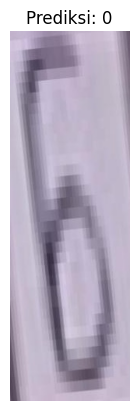

In [19]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

# Transformasi yang digunakan saat pengujian (harus sesuai dengan transformasi validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Sesuaikan ukuran untuk ResNet50 (224x224)
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisasi sesuai training
])

# Load dan preprocess gambar untuk pengujian
img_path = f'{dataset_dir}/6/image_2827.jpg'  # Ubah ke path gambar yang diinginkan
print(img_path)
img = Image.open(img_path)

# Terapkan transformasi dan tambahkan dimensi batch
img = test_transform(img).unsqueeze(0)  # Tambahkan dimensi batch (1, C, H, W)
img = img.to(device)  # Pindahkan gambar ke device (GPU/CPU)

# Prediksi gambar menggunakan model ResNet50
resnet50.eval()  # Set model ke mode evaluasi
with torch.no_grad():  # Nonaktifkan gradien untuk inferensi
    predictions = resnet50(img)  # ResNet50 hanya mengembalikan satu output

    # Ambil kelas dengan probabilitas tertinggi
    _, predicted_class_idx = torch.max(predictions, 1)
    predicted_class_idx = predicted_class_idx.item()

# Dapatkan label kelas dari dataset pelatihan
labels = train_loader.dataset.dataset.classes  # Ambil daftar label dari dataset pelatihan

# Ambil label yang sesuai dengan indeks prediksi
predicted_label = labels[predicted_class_idx]

# Tampilkan hasil prediksi
print(f"Hasil prediksi: {predicted_label}")

# Tampilkan gambar dengan hasil prediksi
plt.imshow(Image.open(img_path))  # Muat ulang gambar untuk ditampilkan
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')  # Hilangkan sumbu untuk tampilan lebih rapi
plt.show()